<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we will practice all the classification algorithms and then compare their accuracy, jaccard similarity, f1 score and logloss.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

<h1 align="center"><font size="3">Final Accuracy Table</font></h1>

| Algorithm          | Accuracy | Jaccard  | F1-score | 
|--------------------|----------|----------|----------|        
| KNN                | 0.62963  | 0.55555  | 0.65190  |         
| Decision Tree      | 0.74074  | 0.72000  | 0.71443  |
| SVM                | 0.74074  | 0.75074  | 0.63041  |
| LogisticRegression | 0.75925  | 0.74000  | 0.72882  |

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [7]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [8]:
df.shape

(346, 10)

### Convert to date time object 

In [9]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



#### Let’s see how many of each class is in our data set 

In [10]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


#### Let's plot some columns to underestand data better:

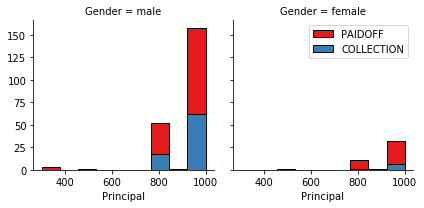

In [12]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

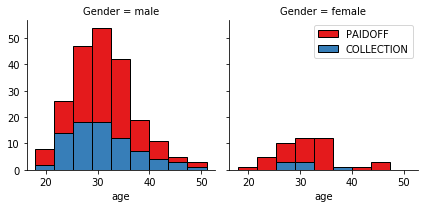

In [13]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

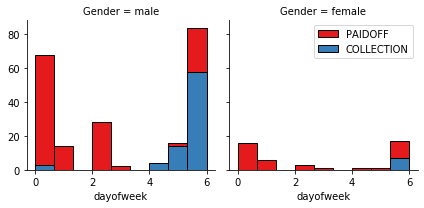

In [14]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [15]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

#### Let's look at gender:

In [16]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


#### Let's convert male to 0 and female to 1:


In [17]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

#### Let's defind feature sets, X:

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [23]:
X_norm = preprocessing.StandardScaler().fit(X).transform(X)
X_norm[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

In this part we will use the training set to build an accurate model. Then test set will be used to report the accuracy of the model
Following algorithm will be used:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_val.shape,  y_val.shape)


Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [33]:
Ks = 20
k = 2
#Train Model and Predict  
n_classifier = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
n_classifier

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [34]:
mean_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict to select the best k 
    n_classifier_multi = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=n_classifier_multi.predict(X_val)
    mean_acc[n-1] = metrics.accuracy_score(y_val, yhat)
     
print("k value that gives maximum accuracy:", mean_acc.argmax()+1)
n_classifier_multi = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train,y_train)

k value that gives maximum accuracy: 7


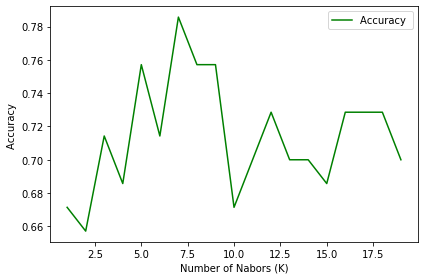

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [28]:
yhat_k_train = n_classifier_multi.predict(X_val)

In [46]:
print("Train set Accuracy: ", metrics.accuracy_score(y_val, yhat_k_train))
yhat_k_train
y_val

Train set Accuracy:  0.7857142857142857


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF'], dtype=object)

In [55]:
print("Jaccard Similarity Score for train set with K Nearest Neighbor: ", jaccard_score(y_val, yhat_k_train, average="binary", pos_label="PAIDOFF"))
print("F1 Score for train set with K Nearest Neighbor: ", f1_score(y_val, yhat_k_train, average='weighted'))

Jaccard Similarity Score for train set with K Nearest Neighbor:  0.765625
F1 Score for train set with K Nearest Neighbor:  0.7766540244416351


# Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
tree_classifier = DecisionTreeClassifier(criterion="entropy")
tree_classifier.fit(X_train,y_train)
yhat_tree = tree_classifier.predict(X_val)
print("Test set Accuracy: ", metrics.accuracy_score(y_val, yhat_tree))

Test set Accuracy:  0.7


In [58]:
mean_acc2 = np.zeros((Ks-1))
max_depth_range = list(range(1, 20))

#to find most optimum depth
for d in max_depth_range:
    tree_classifier = DecisionTreeClassifier(max_depth = d)
    tree_classifier.fit(X_train,y_train)
    yhat_tree = tree_classifier.predict(X_val)
    
    mean_acc2[n-1] = metrics.accuracy_score(y_val, yhat_tree)
    
    
print("depth that gives maximum accuracy:", mean_acc.argmax()+1)

depth that gives maximum accuracy: 7


In [59]:
tree_classifier = DecisionTreeClassifier(max_depth = mean_acc.argmax()+1)
tree_classifier.fit(X_train,y_train)
yhat_tree_train = tree_classifier.predict(X_val)

In [62]:
print("Jaccard Similarity Score for train set with Decision Trees: ", jaccard_score(y_val, yhat_tree_train, average="binary", pos_label="PAIDOFF"))
print("F1 Score for train set with Decision Trees: ", f1_score(y_val, yhat_tree_train, average='weighted'))

Jaccard Similarity Score for train set with Decision Trees:  0.75
F1 Score for train set with Decision Trees:  0.7142857142857142


# Support Vector Machine

In [63]:
from sklearn import svm
from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
yhat_svm_train = clf.predict(X_val)
yhat_svm_train [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [66]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
C_range = 10. ** np.arange(-4, 9)
gamma_range = 10. ** np.arange(-7, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

clf = grid.fit(X_train, y_train) 

In [67]:
#Print results
print("The best parameters are: %s"
      % (grid.best_params_))
print("The best score %0.2f"
      % (grid.best_score_))
print("Total classification error%0.2f"
      % (1-grid.best_score_))

The best parameters are: {'C': 0.0001, 'gamma': 1e-07}
The best score 0.75
Total classification error0.25


In [68]:
print("Jaccard Similarity Score for train set with SVM: ", jaccard_score(y_val, yhat_svm_train, average="binary", pos_label="PAIDOFF"))
print("F1 Score for train set with SVM: ", f1_score(y_val, yhat_svm_train, average='weighted'))

Jaccard Similarity Score for train set with SVM:  0.7272727272727273
F1 Score for train set with SVM:  0.7275882012724117


# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.0001,solver='liblinear')
LR.fit(X_train,y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
yhat_lr_train = LR.predict(X_val)

In [71]:
print("Jaccard Similarity Score for train set with Logistic Regression: ", jaccard_score(y_val, yhat_lr_train, average="binary", pos_label="PAIDOFF"))
print("F1 Score for train set with Logistic Regression: ", f1_score(y_val, yhat_lr_train, average='weighted'))

Jaccard Similarity Score for train set with Logistic Regression:  0.6060606060606061
F1 Score for train set with Logistic Regression:  0.6434120818138576


In [72]:
from sklearn.metrics import log_loss
yhat_prob_train = LR.predict_proba(X_val)
print("Log Loss with train set for Logistic Regression: ", log_loss(y_val, yhat_prob_train))

Log Loss with train set for Logistic Regression:  0.6906988027596805


# Model Evaluation using Test set

### Load Test set for evaluation 

In [101]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [102]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [76]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [103]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()


KeyError: 'dayofweek'

In [78]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [79]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [80]:
X = Feature2
y_test = test_df['loan_status'].values
X_test = preprocessing.StandardScaler().fit(X).transform(X)

In [95]:
# KNN for test set
yhat_k_test = n_classifier.predict(X_test)
accuracy_knn = metrics.accuracy_score(y_test, yhat_k_test)
knn_jaccard = jaccard_score(y_test, yhat_k_test, average="binary", pos_label="PAIDOFF")
knn_f1_score = f1_score(y_test, yhat_k_test, average='weighted')

In [96]:
# DecisionTrees for test set
c = tree_classifier.predict(X_test)
yhat_tree_test = tree_classifier.predict(X_test)
accuracy_tree = metrics.accuracy_score(y_test, yhat_tree_test)
tree_jaccard = jaccard_score(y_test, yhat_tree_test, average="binary", pos_label="PAIDOFF")
tree_f1_score = f1_score(y_test, yhat_tree_test, average='weighted')

In [97]:
# SVM for test set
yhat_svm_test = clf.predict(X_test)
svm_jaccard = jaccard_score(y_test, yhat_svm_test, average="binary", pos_label="PAIDOFF")
svm_f1_score = f1_score(y_test, yhat_svm_test, average='weighted')
accuracy_svm = metrics.accuracy_score(y_test, yhat_svm_test)

In [98]:
# LogisticRegression for test set
yhat_lr_test = LR.predict(X_test)
lr_jaccard = jaccard_score(y_test, yhat_lr_test, average="binary", pos_label="PAIDOFF")
lr_f1_score = f1_score(y_test, yhat_lr_test, average='weighted')
yhat_prob_test = LR.predict_proba(X_test)
lr_logloss =log_loss(y_test, yhat_prob_test)
accuracy_lr = metrics.accuracy_score(y_test, yhat_lr_test)

In [99]:
df_report = pd.DataFrame({"Accuracy":[accuracy_knn, accuracy_tree, accuracy_svm, accuracy_lr],
                         "Jaccard":[knn_jaccard, tree_jaccard, svm_jaccard, lr_jaccard],
                         "F1-score":[knn_f1_score, tree_f1_score, svm_f1_score, lr_f1_score],
                         "LogLoss":[np.nan, np.nan, np.nan, lr_logloss]})
df_report.index.name = "Algorithm"
df_report.index= ["KNN","Decision Tree", "SVM", "Logistic Regression",]  
#np.nan
df.sort_index(inplace=True)

Accuracy Table for all models by using Test Set

# Report
Report the accuracy of the built model using different evaluation metrics:

In [100]:
df_report.head()

,Accuracy,Jaccard,F1-score,LogLoss
KNN,0.629630,0.555556,0.651908,NaN
Decision Tree,0.740741,0.720000,0.714431,NaN
SVM,0.740741,0.740741,0.630418,NaN
Logistic Regression,0.759259,0.740000,0.728821,0.690493


<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>